In [59]:
import edlib
from collections import Counter
from tqdm import tqdm
import gzip
import pandas as pd
import multiprocessing
import functools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def rev_compl(seq):
    return seq.translate(str.maketrans("ACGT", "TGCA"))[::-1]


def read_fq(f):
    reads = list()
    for idx, line in enumerate(f):
        if len(reads) >5_000_000:
            break
        if idx % 4 == 1:
            reads.append(line.strip())
    return reads

In [3]:
seqs = (
    ("GPS_a5", "AAGCAGTGGTATCAACGCAGAGTACAT"),
    ("GPS_a3", "CTACACGACGCTCTTCCGATCT"),
    ("TSO", "AAGCAGTGGTATCAACGCAGAGTACATGGG"),
    ("SR_a3", "AGATCGGAAGAGCGTCGTGTAG"),
    ("pT", "TTTTTTTTTTTT"),
    ("LR_a3", "GCAATACGTAACTGAACGAAGT"),
    ("LR_a5", "AATGTACTTCGTTCAGTTACGTATTGCT"),
)
seqs = [(name, seq) for name, seq in seqs] + [
    (name + "'", rev_compl(seq)) for name, seq in seqs
]

In [60]:
TKSM_reads = read_fq(
    open(
        "output/simulate/TKSM/S1_chr21/Mrg.plA.Trc.Tag.SCB.Tag.PCR.Flp.Tag.Shf.Seq.fastq"
    )
)
EXML_reads = read_fq(gzip.open("extern/scNanoGPS/example/fastq/example.fastq.gz", "rt"))
N1_reads = read_fq(
    gzip.open(
        "/groups/hachgrp/projects/col-flannigan-scrna-2022-oct/raw-data/nano/13032-N1-GSC_pass.fastq.gz",
        "rt",
    )
)

In [61]:
def align_read(seq, read):
    aln = edlib.align(seq, read, mode="HW", task="locations")
    if aln["editDistance"] <= 3:
        slen = aln["locations"][0][0]
        elen = len(read) - aln["locations"][0][1]
        if slen < elen:
            return slen
        else:
            return -elen
    else:
        return None


def align(seq, reads):
    C = Counter()
    f = functools.partial(align_read, seq)
    with multiprocessing.Pool(64) as pool:
        for c in pool.map(f, reads):
            C[c] += 1
    return C


# Build a dataframe with the counts using the TKSM reads and get_counts method
TKSM_counts = dict()
EXML_counts = dict()
N1_counts = dict()
for name, seq in tqdm(seqs):
    TKSM_counts[name] = align(seq, TKSM_reads)
    EXML_counts[name] = align(seq, EXML_reads)
    N1_counts[name] = align(seq, N1_reads)

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [11:21<00:00, 48.71s/it]


14it [00:00, 30.96it/s]


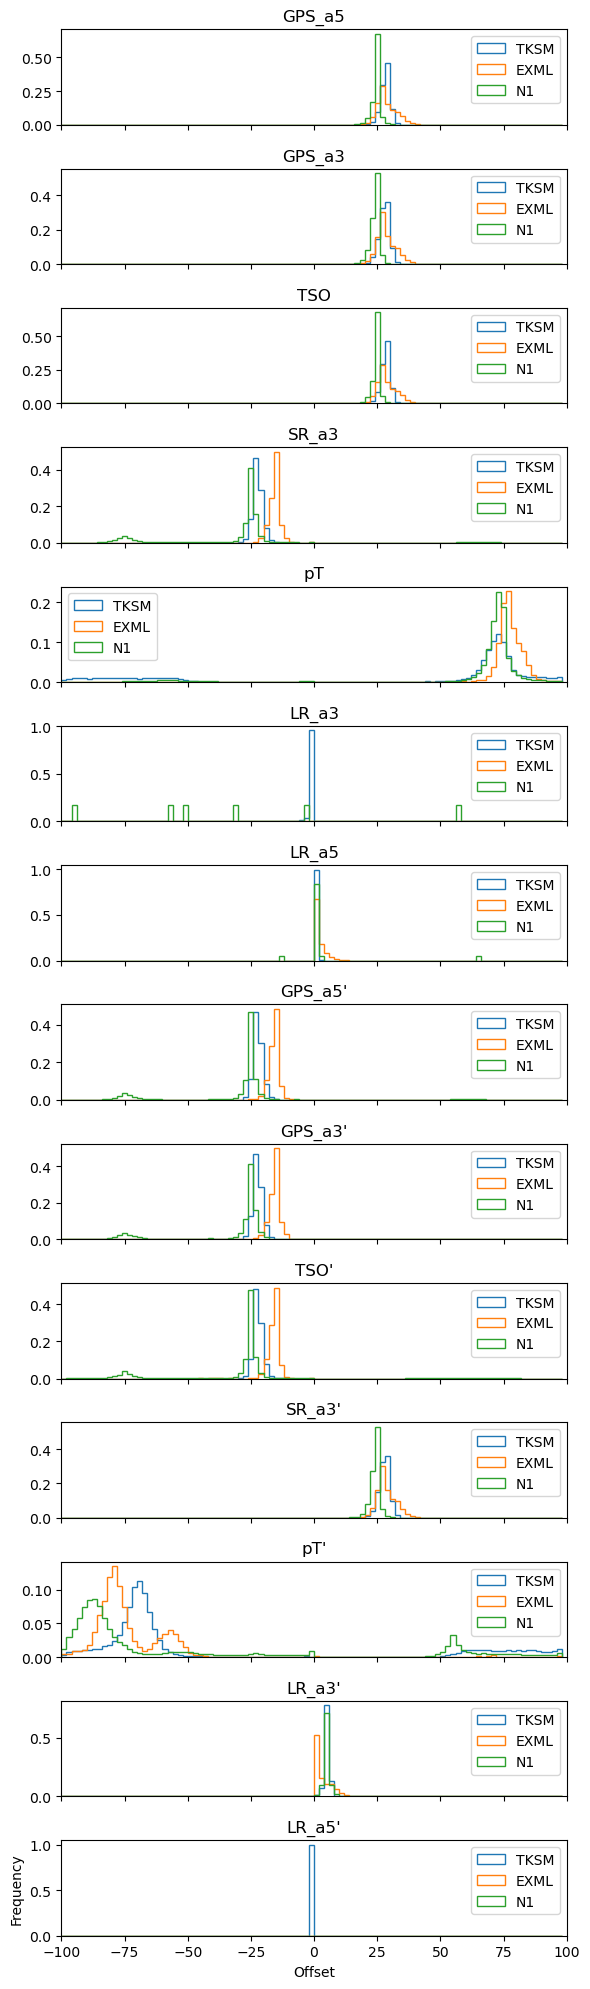

In [67]:
fig, axes = plt.subplots(len(seqs[:]), 1, figsize=(6, 20), sharex=True)

# collect legend
for ax, (name, _) in tqdm(zip(axes, seqs[:])):
    for C, label in [
        (TKSM_counts, "TKSM"),
        (EXML_counts, "EXML"),
        (N1_counts, "N1"),
    ]:
        xvals = [k for k in C[name].keys() if k is not None and -100 < k < 100]
        yvals = [C[name][x] for x in xvals]
        yvals = np.array(yvals) / sum(yvals)
        ax.hist(xvals, bins=range(-100,100,2), weights=yvals, alpha=1, label=label, histtype="step")
    ax.set_xlim(-100, 100)
    ax.set_title(name)
    ax.legend()
axes[-1].set_xlabel("Offset")
axes[-1].set_ylabel("Frequency")
axes[-1].legend()

fig.tight_layout()
plt.show()